In [73]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go # for visualizing 3d plots
import plotly


In [2]:
data = np.load('ca3_out.npy')
time = np.load('ca3_t.npy')

print(data.shape)
print(time.shape)

(14106, 6732)
(6732,)


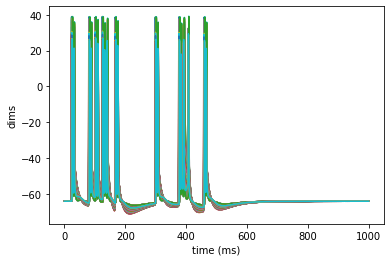

In [3]:
for dim in range(14000,14100):
    plt.plot(time, data[dim,:])
plt.ylabel('dims')
plt.xlabel('time (ms)')
plt.show()

In [4]:

def normalize_sim_df(df):
    # normalize each dimension of the simulation data to fit in range [-1,1]
    biases = []
    scalars = []
    unchanging_params = []
    
    sim_df_norm = np.zeros(df.shape)
    
    for dim in range(df.shape[0]):
        bias = np.mean((np.min(df[dim,:]), np.max(df[dim,:])))
        biases.append(bias)
        scalar = -(np.min(df[dim,:]) - np.max(df[dim,:]))/2
        
        if scalar == 0:
            scalar = 1
            unchanging_params.append(dim)
        scalars.append(scalar)
        
        sim_df_norm[dim,:] = (df[dim,:] - bias)/scalar

    return sim_df_norm, biases, scalars, unchanging_params

In [14]:
data_norm, biases, scalars, unchanging_params = normalize_sim_df(data)

print(data_norm.shape)

# remove unchanging params
data_norm = np.delete(data_norm, unchanging_params, 0)

# remove from biases and scalars as well
biases = [b for i, b in enumerate(biases) if i not in unchanging_params]
scalars = [s for i, s in enumerate(scalars) if i not in unchanging_params]

print(data_norm.shape)

(14106, 6732)
(13163, 6732)


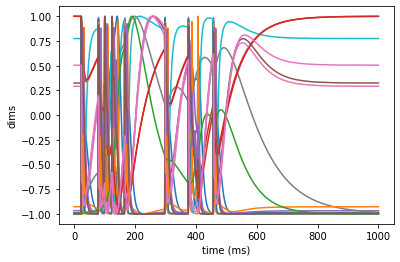

In [17]:
for dim in [0,1,2,3,4,5,6,7,8,9,14,13000,1000,100, 3000, 9000, 12000]:
    plt.plot(time, data_norm[dim,:])
plt.ylabel('dims')
plt.xlabel('time (ms)')
plt.show()

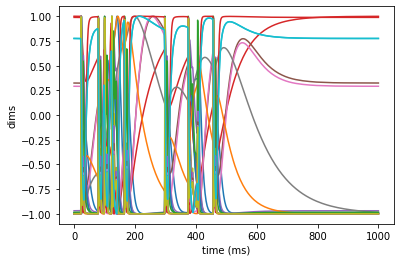

In [97]:
for dim in range(0,20):
    plt.plot(time, data_norm[dim,:])
plt.ylabel('dims')
plt.xlabel('time (ms)')
plt.show()

In [18]:
def denormalize_sim_df(norm_df, biases, scalars):
    # reverse of normalize_sim_df()
    sim_df_denorm = np.zeros(norm_df.shape)
    
    for dim in range(norm_df.shape[0]):
        sim_df_denorm[dim,:] = (norm_df[dim,:]*scalars[dim]) + biases[dim]
    
    return sim_df_denorm

data_denorm = denormalize_sim_df(data_norm, biases, scalars)

## Voxelization

In [25]:
from collections import defaultdict
import random

In [26]:
def voxelate(df, voxels_per_dimension, n_points_per_voxel = 1):
    # df: data to voxelate of shape (n_dims, n_obvs)
    # voxels_per_dimension: list of number of voxels per dimension of len n_dims
    n_dims = len(voxels_per_dimension)
    n_obvs = df.shape[1]
    
    # generate voxel bins for each dimension
    voxels = []
    for i in range(n_dims):
        dim_min = min(df[i,:])
        dim_max = max(df[i,:])
        
        # add roughly 1 buffer voxel to either end
        buffer_voxel_len = (dim_max - dim_min)/voxels_per_dimension[i]
        dim_min = dim_min - buffer_voxel_len
        dim_max = dim_max + buffer_voxel_len
        
        # create dim_voxels
        dim_voxels = np.linspace(start = dim_min, stop = dim_max, num = voxels_per_dimension[i])
        
        voxels.append(dim_voxels)
        
    # digitize data
    digitized_df = []
    for i in range(n_dims):
        digitized_df.append(np.digitize(df[i,:], voxels[i], right=True))
    digitized_df = np.vstack(digitized_df)
    
    # use a defaultdict to store occupied voxels and thier points
    occupied_voxels = defaultdict(list)
    
    for j in range(n_obvs):
        #print(digitized_df[:,j])
        voxel_hash = [str(x) for x in list(digitized_df[:,j])]
        voxel_hash = '_'.join(voxel_hash)
        occupied_voxels[voxel_hash].append(j)
        
    # choose n_points_per_voxel random point(s) from each voxel 
    #TODO: this method should be tested agaisnt other methods
    sampled_points = []
    point_inds = []
    for voxel in occupied_voxels:
        obvs = random.sample(occupied_voxels[voxel], k = min(n_points_per_voxel, len(occupied_voxels[voxel])))
        for obv in obvs:
            sampled_points.append(df[:,obv])
            point_inds.append(obv)
    sampled_points = np.vstack(sampled_points)
    
    return sampled_points.T, point_inds
    
sampled_points, point_inds = voxelate(data_norm, [100,100,100,100])

In [27]:
sampled_points.shape

(13163, 2396)

In [28]:
data_norm.shape

(13163, 6732)

## Run diffusion maps

In [58]:
# generate gaussian kernel matrix
from scipy.spatial.distance import pdist, squareform

def calc_kernel(W, alpha):
    # pairwise dists
    pairwise_dists = squareform(pdist(W, 'euclidean'))
    # kernel function
    K = np.exp(-pairwise_dists ** 2 / alpha)
    return K

def calc_p_prime(K):
    r = np.sum(K, axis=0)
    Di = np.diag(1/r)

    # diffusion matrix
    P = np.matmul(Di, K)

    D_right = np.diag((r)**0.5)

    # D^(-1/2) matrix
    D_left = np.diag((r)**-0.5)

    # symmetrized diffusion matrix P
    P_prime = np.matmul(D_right, np.matmul(P,D_left))
    
    return P_prime, D_left

def eigen_decomp(P_prime):
    # eigenvalue decomposition
    eigVals, eigVecs = np.linalg.eig(P_prime)
    
    return eigVals, eigVecs

def diffusion_map(eigVals, eigVecs, D_left, n_dims):
    # sort by eigenVals
    idx = eigVals.argsort()[::-1]
    eigVals_sorted = eigVals[idx]
    eigVecs_sorted = eigVecs[:,idx]

    diffusion_coordinates = np.matmul(D_left, eigVecs_sorted)

    #diffusion_map = diffusion_coordinates[:,:n_dims]
    diffusion_map = diffusion_coordinates
    
    return diffusion_map, eigVals_sorted

In [20]:
# run diffusion maps
alpha = 0.15 # kernel bandwidth parameter
n_dims = 3

In [32]:
pairwise_dists = squareform(pdist(sampled_points.T, 'euclidean'))

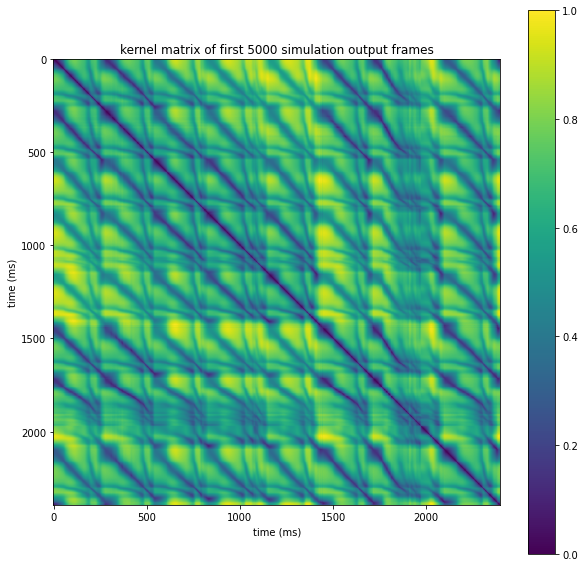

In [53]:
# kernel matrix visualized

pairwise_dists = pairwise_dists / np.max(pairwise_dists)

plt.figure(figsize=(10,10))
plt.imshow(pairwise_dists)
plt.title('kernel matrix of first 5000 simulation output frames')
plt.xlabel('time (ms)')
plt.ylabel('time (ms)')
plt.colorbar()
plt.show()

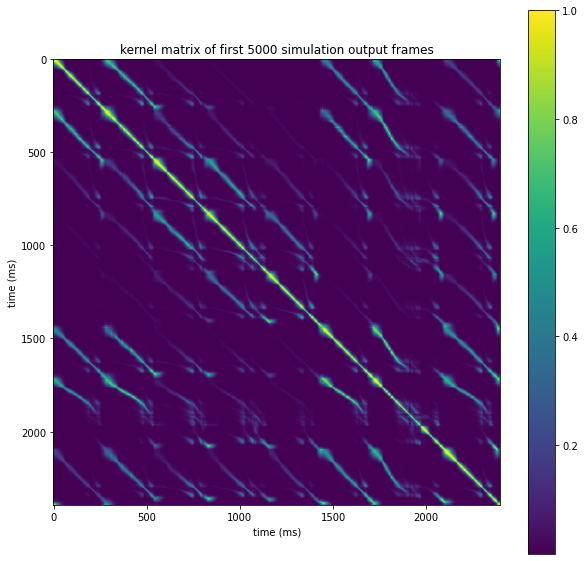

In [98]:
# kernel function
alpha = .05

K = np.exp(-pairwise_dists ** 2 / alpha)

# kernel matrix visualized
plt.figure(figsize=(10,10))
plt.imshow(K)
plt.title('kernel matrix of first 5000 simulation output frames')
plt.xlabel('time (ms)')
plt.ylabel('time (ms)')
plt.colorbar()
plt.show()

In [99]:
P_prime, D_left = calc_p_prime(K)
eigVals, eigVecs = eigen_decomp(P_prime)
dm, eigVals_sorted = diffusion_map(eigVals, eigVecs, D_left, n_dims)

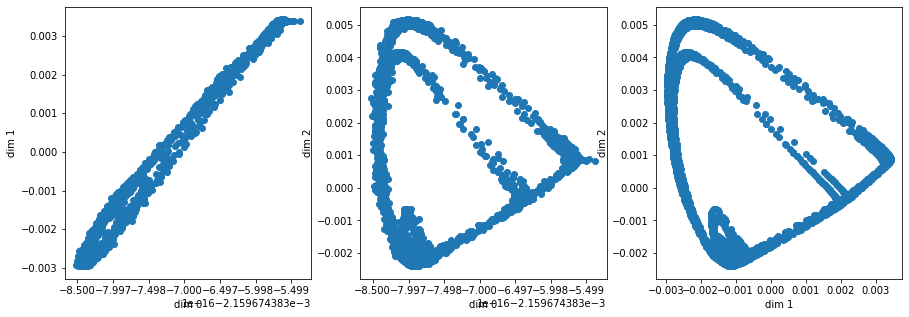

In [100]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(dm[:,0], dm[:,1])
plt.xlabel('dim 0')
plt.ylabel('dim 1')

plt.subplot(132)
plt.scatter(dm[:,0], dm[:,2])
plt.xlabel('dim 0')
plt.ylabel('dim 2')

plt.subplot(133)
plt.scatter(dm[:,1], dm[:,2])
plt.xlabel('dim 1')
plt.ylabel('dim 2')

plt.show()

Text(0, 0.5, 'dim 2')

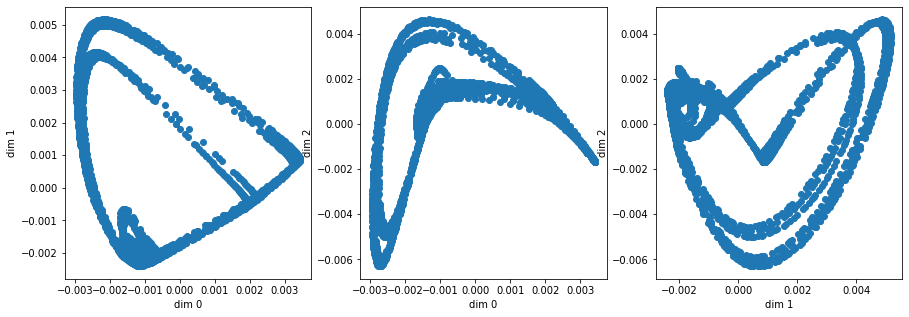

In [101]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(dm[:,1], dm[:,2])
plt.xlabel('dim 0')
plt.ylabel('dim 1')

plt.subplot(132)
plt.scatter(dm[:,1], dm[:,3])
plt.xlabel('dim 0')
plt.ylabel('dim 2')

plt.subplot(133)
plt.scatter(dm[:,2], dm[:,3])
plt.xlabel('dim 1')
plt.ylabel('dim 2')

(array([1425., 2396.,  207., 1579., 1056.,   23.,    9.,    9.,   13.,
          15.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

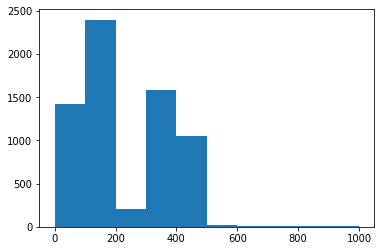

In [112]:
plt.hist(list(time))

In [115]:
# 3d plot over n, h, and m

tstop = 3000

import plotly.express as px
# Configure the trace.
trace = go.Scatter3d(
    x = dm[:,1], # m
    y = dm[:,2], # h
    z = dm[:,3], # n
    mode='markers',
    marker={
        'size': 2,
        'color':list(range(len(list(time)))), 
        'opacity': 0.5,
        'showscale':True
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene = dict(
        xaxis_title='dm1',
        yaxis_title='dm2',
        zaxis_title='dm3'
    )
)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [61]:
import numpy as np
from sklearn.decomposition import PCA

In [65]:
pca = PCA(n_components=3)
pcs = pca.fit_transform(sampled_points.T)

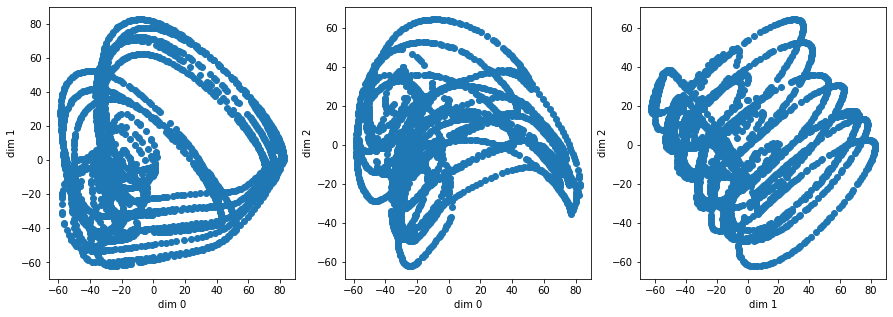

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(pcs[:,0], pcs[:,1])
plt.xlabel('dim 0')
plt.ylabel('dim 1')

plt.subplot(132)
plt.scatter(pcs[:,0], pcs[:,2])
plt.xlabel('dim 0')
plt.ylabel('dim 2')

plt.subplot(133)
plt.scatter(pcs[:,1], pcs[:,2])
plt.xlabel('dim 1')
plt.ylabel('dim 2')

plt.show()

In [116]:
# 3d plot over n, h, and m

# Configure the trace.
trace = go.Scatter3d(
    x = pcs[:,0], # m
    y = pcs[:,1], # h
    z = pcs[:,2], # n
    mode='markers',
    marker={
        'size': 2,
        'color':list(range(len(list(time)))), 
        'opacity': 0.5,
        'showscale':True
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene = dict(
        xaxis_title='m',
        yaxis_title='h',
        zaxis_title='n'
    )
)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)